# Wildfire Data Prediction: Modeling Fire Perimeter
#### Fire Atlas Dataset + NCDC GSOM + NCDC Monthly Normals

Andrew McDonald // CSE 847 // April 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

pd.set_option("display.max_rows", 11)
cmap = plt.get_cmap("tab10")

In [2]:
# note that data have been pre-standardized and one-hot-encoded
X_df = pd.read_csv("data/X.csv")
y_df = pd.read_csv("data/y.csv")
display(X_df)
display(y_df)

,latitude,longitude,expansion,fire_line,speed,gsom_elevation,gsom_latitude,gsom_longitude,normal_elevation,normal_latitude,...,land_Deciduous_Broadleaf_forest,land_Evergreen_Broadleaf_forest,land_Evergreen_Needleleaf_forest,land_Grasslands,land_Mixed_forest,land_Open_shrublands,land_Savannas,land_Urban_and_built-up,land_Water,land_Woody_savannas
0,-2.037295,-3.775066,-0.252021,-0.463854,-0.521389,-0.666190,-2.210360,-3.751664,-0.669767,-2.066734,...,0,0,0,0,0,0,0,0,0,0
1,-2.037819,-3.775388,-0.154127,-0.241580,-0.277415,-0.666190,-2.210360,-3.751664,-0.669767,-2.066734,...,0,0,0,0,0,0,0,0,0,0
2,-2.041446,-3.776611,-0.028264,0.038055,-0.411601,-0.666190,-2.210360,-3.751664,-0.669767,-2.066734,...,0,0,0,0,0,0,0,0,0,0
3,-2.064307,-3.764382,2.279230,3.816712,2.296511,-0.666190,-2.210360,-3.751664,0.935630,-2.092022,...,0,0,0,0,0,1,0,0,0,0
4,0.630224,-1.552103,0.272409,0.697706,-0.009044,1.482899,0.627030,-1.554420,1.555511,0.706526,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9920,0.456748,1.260933,-0.028264,0.038055,-0.411601,0.216160,0.472003,1.256642,0.229821,0.473678,...,1,0,0,0,0,0,0,0,0,0
9921,0.402737,1.355128,0.118576,0.367881,-0.192024,-0.406249,0.419722,1.351068,-0.529029,0.387607,...,0,0,0,0,1,0,0,0,0,0
9922,0.353911,1.497763,-0.259014,-0.478194,-0.472594,-0.636157,0.395035,1.491636,-0.664816,0.358942,...,1,0,0,0,0,0,0,0,0,0
9923,0.351318,1.497125,-0.028264,0.038055,0.051950,-0.636157,0.395035,1.491636,-0.664816,0.358942,...,0,0,0,0,1,0,0,0,0,0


,size,perimeter,duration
0,0.86,4.63,8
1,1.50,6.48,6
2,0.43,2.78,1
3,18.65,30.56,5
4,0.86,5.56,1
...,...,...,...
9920,0.43,2.78,1
9921,0.64,3.70,1
9922,0.86,4.63,9
9923,3.00,9.26,7


In [3]:
X = X_df.values
y = y_df["perimeter"].values
type(X), type(y), X.shape, y.shape

(numpy.ndarray, numpy.ndarray, (9925, 140), (9925,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=847, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6947, 140), (6947,), (2978, 140), (2978,))

In [5]:
# initialize empty list to store dictionaries of model performance metrics
performance = {}

## 1. Unregularized Linear Model
Baseline for comparison purposes.

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

y_hat_linear = model_linear.predict(X_test)
performance["LinearRegression"] = {
    "model": "LinearRegression",
    "mean_squared_error": mean_squared_error(y_test, y_hat_linear),
    "mean_absolute_error": mean_absolute_error(y_test, y_hat_linear),
    "pearsonr": pearsonr(y_test, y_hat_linear)[0],
}
performance["LinearRegression"]

{'model': 'LinearRegression',
 'mean_squared_error': 26.271537016085176,
 'mean_absolute_error': 2.390772353172943,
 'pearsonr': 0.8551210135270274}

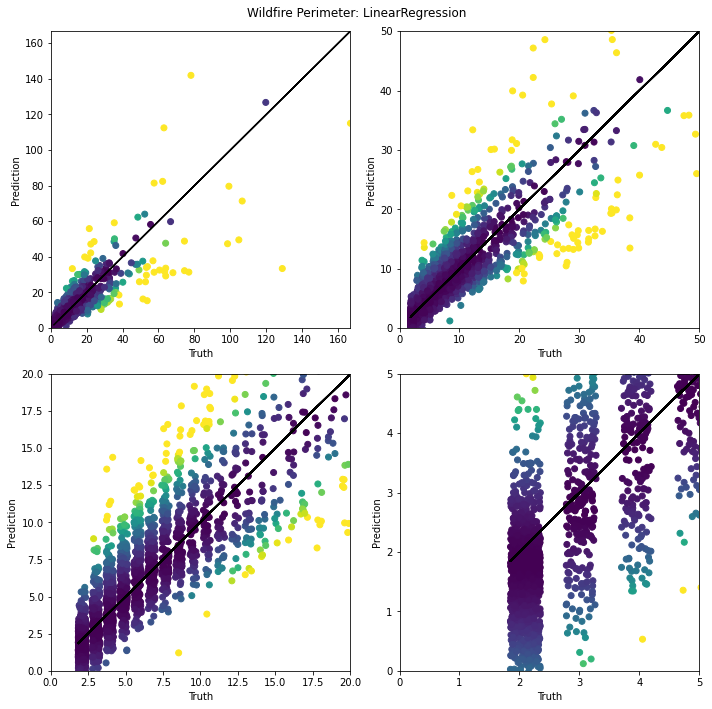

In [8]:
def plot_predictions(y_true, y_hat, model_name):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.ravel()
    max_lim = np.amax((y_true, y_hat))
    for i, limits in enumerate([(0, max_lim), (0, 50), (0, 20), (0, 5)]):
        jitter = np.random.random(y_true.shape) / 2        # avoid overlapping x on small scales
        ax[i].scatter(y_true + jitter, y_hat, c=(y_true - y_hat)**2, vmax=limits[1]*2)
        ax[i].plot(y_true, y_true, c="k")
        ax[i].set_xlabel("Truth")
        ax[i].set_xlim(limits)
        ax[i].set_ylabel("Prediction")
        ax[i].set_ylim(limits)
    fig.suptitle(f"Wildfire Perimeter: {model_name}")

    plt.tight_layout()
    plt.show()

plot_predictions(y_test, y_hat_linear, "LinearRegression")

## 2. Ridge Linear Model
Cross-validated regularized model for baseline purposes.

In [9]:
from sklearn.linear_model import Ridge

In [10]:
kf = KFold(n_splits=3)
alphas = np.logspace(start=-5, stop=5)
stats = []

for alpha in alphas:
    mse, mae, rho = 0, 0, 0
    for t_idx, v_idx in kf.split(X_train):
        model_ridge = Ridge(alpha=alpha)
        model_ridge.fit(X_train[t_idx], y_train[t_idx])
        y_hat = model_ridge.predict(X_train[v_idx])
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
    stats.append({
        "alpha": alpha,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })

ridge_cv = pd.DataFrame(stats)


In [11]:
ridge_cv.describe()

,alpha,mean_squared_error,mean_absolute_error,pearsonr
count,50.000000,50.000000,50.000000,50.000000
mean,5334.118409,55.147717,2.733106,0.853804
std,17490.215129,21.728820,0.624982,0.013001
min,0.000010,41.426816,2.270592,0.811146
25%,0.003233,44.237420,2.496789,0.845487
50%,1.027730,50.922990,2.556851,0.849613
75%,322.310935,51.318412,2.562086,0.866618
max,100000.000000,142.340486,5.065026,0.872671


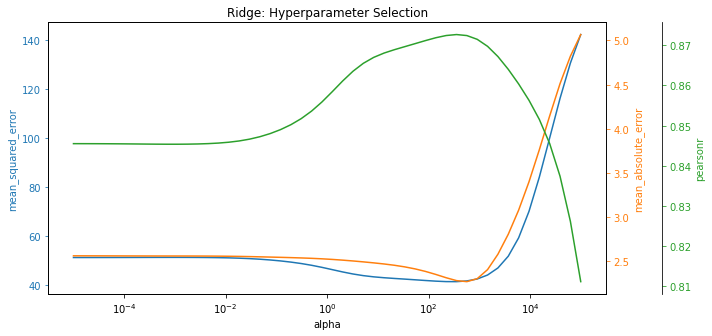

In [12]:
def plot_choosing_single_param(df, param, model_name):
    fig, ax1 = plt.subplots(figsize=(10,5))

    df.plot(x=param, y="mean_squared_error", ax=ax1, color=cmap(0), legend=False)
    ax1.set_ylabel("mean_squared_error", color=cmap(0))
    ax1.tick_params('y', colors=cmap(0))

    ax2 = ax1.twinx()
    df.plot(x=param, y="mean_absolute_error", ax=ax2, color=cmap(1), legend=False)
    ax2.set_ylabel("mean_absolute_error", color=cmap(1))
    ax2.tick_params('y', colors=cmap(1))

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.1))
    df.plot(x=param, y="pearsonr", ax=ax3, color=cmap(2), legend=False)
    ax3.set_ylabel("pearsonr", color=cmap(2))
    ax3.tick_params('y', colors=cmap(2))

    plt.xlabel(param)
    plt.xscale("log")
    plt.title(f"{model_name}: Hyperparameter Selection")
    plt.show()

plot_choosing_single_param(ridge_cv, "alpha", "Ridge")

In [13]:
idx = ridge_cv["mean_squared_error"].idxmin(axis=0)
best_alpha = ridge_cv.loc[idx, "alpha"]
best_alpha

355.64803062231283

In [14]:
model_ridge = Ridge(alpha=best_alpha)
model_ridge.fit(X_train, y_train)

y_hat_ridge = model_ridge.predict(X_test)
performance["Ridge"] = {
    "model": "Ridge",
    "mean_squared_error": mean_squared_error(y_test, y_hat_ridge),
    "mean_absolute_error": mean_absolute_error(y_test, y_hat_ridge),
    "pearsonr": pearsonr(y_test, y_hat_ridge)[0],
    "alpha": best_alpha
}
performance["Ridge"]

{'model': 'Ridge',
 'mean_squared_error': 25.781840431565072,
 'mean_absolute_error': 2.2212973293901785,
 'pearsonr': 0.8575115249369032,
 'alpha': 355.64803062231283}

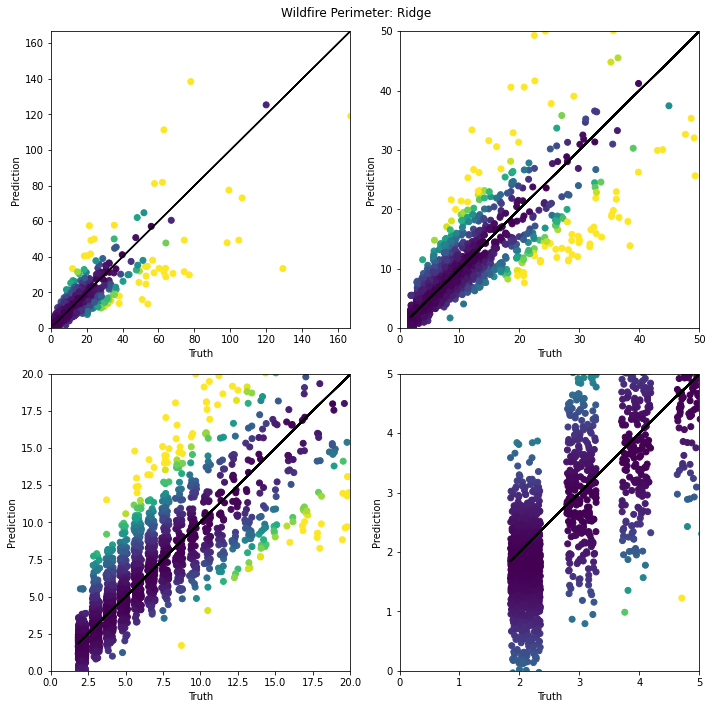

In [15]:
plot_predictions(y_test, y_hat_ridge, "Ridge")


## 3. Lasso Linear Model
Cross-validated regularized model for baseline purposes.

In [16]:
from sklearn.linear_model import Lasso

In [17]:
kf = KFold(n_splits=3)
alphas = np.logspace(start=-5, stop=1, num=7)
stats = []

for alpha in alphas:
    mse, mae, rho = 0, 0, 0
    for t_idx, v_idx in kf.split(X_train):
        model_lasso = Lasso(alpha=alpha, tol=1e-2, max_iter=1e4)
        model_lasso.fit(X_train[t_idx], y_train[t_idx])
        y_hat = model_lasso.predict(X_train[v_idx])
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
    stats.append({
        "alpha": alpha,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })
    print(f"Finished alpha = {alpha}.")

lasso_cv = pd.DataFrame(stats)

c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92428.84472793953, tolerance: 9580.6019043157
  model = cd_fast.enet_coordinate_descent(
c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62373.130879277756, tolerance: 5266.252303999997
  model = cd_fast.enet_coordinate_descent(
c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75118.60229811855, tolerance: 8649.072118748712
  model = cd_fast.enet_coordinate_descent(
c:\users\andre\appdata\

Finished alpha = 1e-05.
Finished alpha = 0.0001.
Finished alpha = 0.001.
Finished alpha = 0.01.
Finished alpha = 0.1.
Finished alpha = 1.0.
Finished alpha = 10.0.


In [18]:
lasso_cv.describe()

,alpha,mean_squared_error,mean_absolute_error,pearsonr
count,7.000000,7.000000,7.000000,6.000000
mean,1.587301,60.441531,2.848681,0.860803
std,3.727676,38.363308,0.998370,0.010435
min,0.000010,41.513628,2.140582,0.847949
25%,0.000550,43.089851,2.446892,0.852104
50%,0.010000,48.578020,2.542045,0.861759
75%,0.550000,49.875072,2.644856,0.869358
max,10.000000,147.069225,5.074643,0.872576


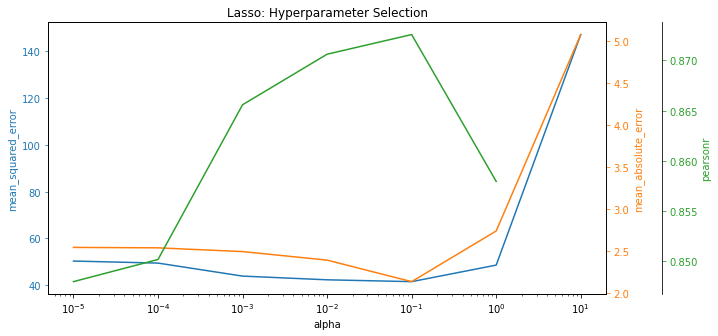

In [19]:
plot_choosing_single_param(lasso_cv, "alpha", "Lasso")

In [20]:
idx = lasso_cv["mean_squared_error"].idxmin(axis=0)
best_alpha = lasso_cv.loc[idx, "alpha"]
best_alpha

0.1

In [21]:
model_lasso = Lasso(alpha=best_alpha)
model_lasso.fit(X_train, y_train)

y_hat_lasso = model_lasso.predict(X_test)
performance["Lasso"] = {
    "model": "Lasso",
    "mean_squared_error": mean_squared_error(y_test, y_hat_lasso),
    "mean_absolute_error": mean_absolute_error(y_test, y_hat_lasso),
    "pearsonr": pearsonr(y_test, y_hat_lasso)[0],
    "alpha": best_alpha
}
performance["Lasso"]

{'model': 'Lasso',
 'mean_squared_error': 26.200178268365914,
 'mean_absolute_error': 2.064252307001022,
 'pearsonr': 0.8549999331306513,
 'alpha': 0.1}

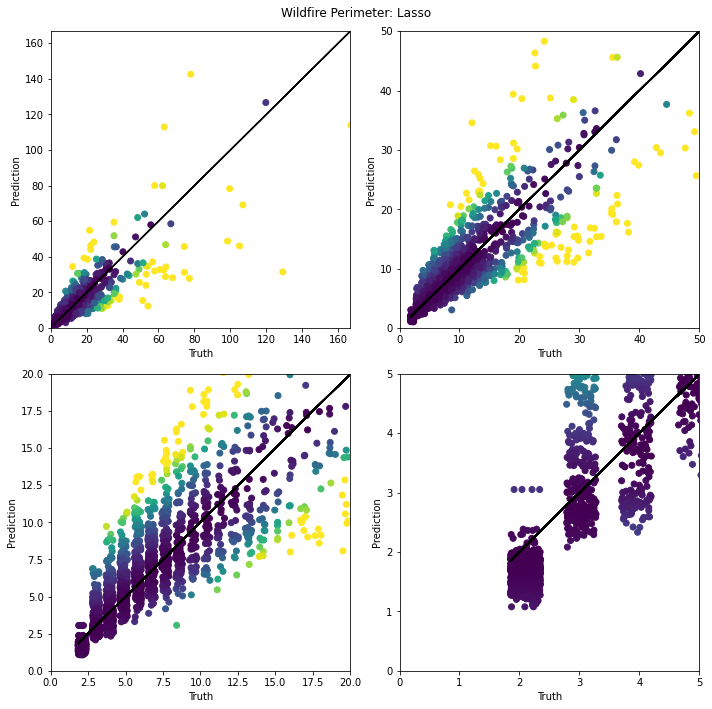

In [22]:
plot_predictions(y_test, y_hat_lasso, "Lasso")



## 4. ElasticNet Linear Model
Cross-validated regularized model for baseline purposes.

In [23]:
from sklearn.linear_model import ElasticNet

In [24]:
kf = KFold(n_splits=3)
alphas = np.logspace(start=-2, stop=0, num=5)
l1_ratios = [0.2, 0.4, 0.6, 0.8]    # 0 and 1 are tested by ridge and lasso
params = [(a, r) for a in alphas for r in l1_ratios]
stats = []

for alpha, l1_ratio in params:
    mse, mae, rho = 0, 0, 0
    for t_idx, v_idx in kf.split(X_train):
        model_elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, tol=1e-2, max_iter=1e4)
        model_elastic.fit(X_train[t_idx], y_train[t_idx])
        y_hat = model_elastic.predict(X_train[v_idx])
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
    stats.append({
        "alpha": alpha,
        "l1_ratio": l1_ratio,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })
    print(f"Finished (alpha, l1_ratio) = {alpha, l1_ratio}.")

elastic_cv = pd.DataFrame(stats)

Finished (alpha, l1_ratio) = (0.01, 0.2).
Finished (alpha, l1_ratio) = (0.01, 0.4).
Finished (alpha, l1_ratio) = (0.01, 0.6).
Finished (alpha, l1_ratio) = (0.01, 0.8).
Finished (alpha, l1_ratio) = (0.03162277660168379, 0.2).
Finished (alpha, l1_ratio) = (0.03162277660168379, 0.4).
Finished (alpha, l1_ratio) = (0.03162277660168379, 0.6).
Finished (alpha, l1_ratio) = (0.03162277660168379, 0.8).
Finished (alpha, l1_ratio) = (0.1, 0.2).
Finished (alpha, l1_ratio) = (0.1, 0.4).
Finished (alpha, l1_ratio) = (0.1, 0.6).
Finished (alpha, l1_ratio) = (0.1, 0.8).
Finished (alpha, l1_ratio) = (0.31622776601683794, 0.2).
Finished (alpha, l1_ratio) = (0.31622776601683794, 0.4).
Finished (alpha, l1_ratio) = (0.31622776601683794, 0.6).
Finished (alpha, l1_ratio) = (0.31622776601683794, 0.8).
Finished (alpha, l1_ratio) = (1.0, 0.2).
Finished (alpha, l1_ratio) = (1.0, 0.4).
Finished (alpha, l1_ratio) = (1.0, 0.6).
Finished (alpha, l1_ratio) = (1.0, 0.8).


In [25]:
elastic_cv.describe()

,alpha,l1_ratio,mean_squared_error,mean_absolute_error,pearsonr
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.291570,0.500000,43.674892,2.388683,0.870182
std,0.380037,0.229416,3.679714,0.228043,0.003527
min,0.010000,0.200000,41.154530,2.138612,0.863348
25%,0.031623,0.350000,41.381037,2.229653,0.870394
50%,0.100000,0.500000,42.275355,2.321053,0.870952
75%,0.316228,0.650000,43.174662,2.412230,0.872782
max,1.000000,0.800000,53.071304,2.881330,0.873437


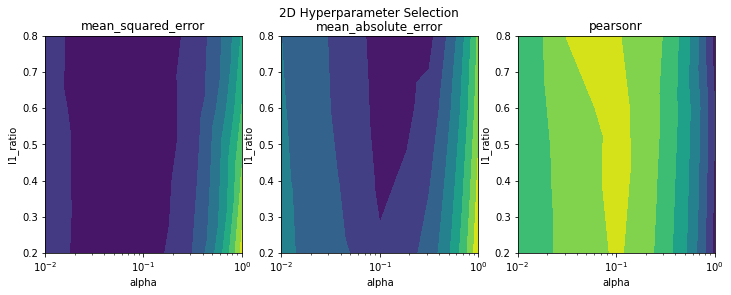

In [26]:
def plot_choosing_two_params(df, param_1, param_2, scale_1, scale_2):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    for i, loss in enumerate(["mean_squared_error", "mean_absolute_error", "pearsonr"]):
        ax[i].tricontourf(df[param_1], df[param_2], df[loss])
        ax[i].set_xlabel(param_1)
        ax[i].set_xscale(scale_1)
        ax[i].set_ylabel(param_2)
        ax[i].set_yscale(scale_2)
        ax[i].set_title(loss)

    fig.suptitle("2D Hyperparameter Selection")
    plt.show()

plot_choosing_two_params(elastic_cv, "alpha", "l1_ratio", "log", "linear")

In [27]:
idx = elastic_cv["mean_squared_error"].idxmin(axis=0)
best_alpha, best_ratio = elastic_cv.loc[idx, "alpha"], elastic_cv.loc[idx, "l1_ratio"]
best_alpha, best_ratio

(0.1, 0.6)

In [28]:
model_elastic = ElasticNet(alpha=best_alpha, l1_ratio=best_ratio)
model_elastic.fit(X_train, y_train)

y_hat_elastic = model_elastic.predict(X_test)
performance["ElasticNet"] = {
    "model": "ElasticNet",
    "mean_squared_error": mean_squared_error(y_test, y_hat_elastic),
    "mean_absolute_error": mean_absolute_error(y_test, y_hat_elastic),
    "pearsonr": pearsonr(y_test, y_hat_elastic)[0],
    "alpha": best_alpha,
    "l1_ratio": best_ratio
}
performance["ElasticNet"]

{'model': 'ElasticNet',
 'mean_squared_error': 25.869563273131156,
 'mean_absolute_error': 2.0798324551661436,
 'pearsonr': 0.8568950384144466,
 'alpha': 0.1,
 'l1_ratio': 0.6}

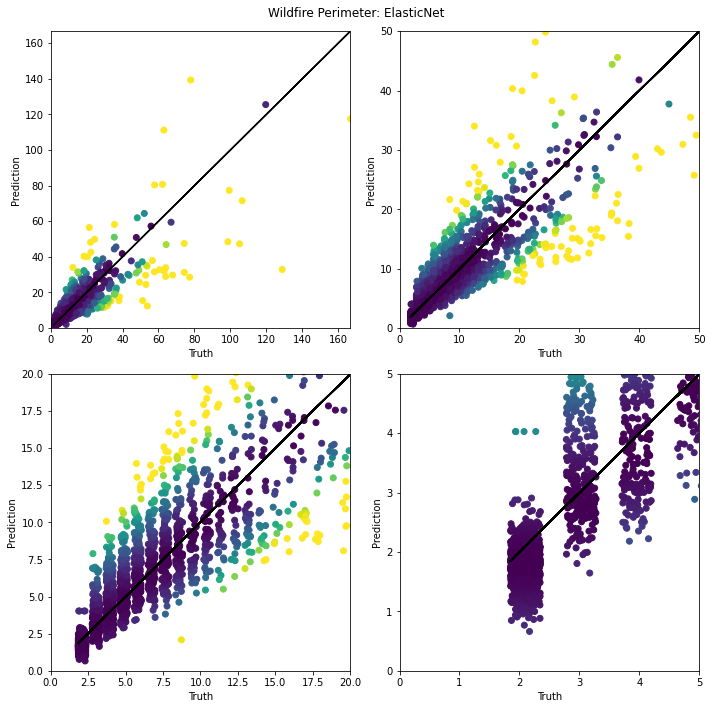

In [29]:
plot_predictions(y_test, y_hat_elastic, "ElasticNet")

## 5. Nonlinear Kernel Ridge Model
Nonlinear model for greater capacity. Begin by choosing best kernel, then optimize kernel parameters.

In [30]:
from sklearn.kernel_ridge import KernelRidge

In [31]:
kf = KFold(n_splits=3)
kernels = ["linear", "poly", "rbf", "cosine"]
stats = []

for kernel in kernels:
    mse, mae, rho = 0, 0, 0
    for t_idx, v_idx in kf.split(X_train):
        model_krr = KernelRidge(kernel=kernel)
        model_krr.fit(X_train[t_idx], y_train[t_idx].reshape(-1, 1))
        y_hat = model_krr.predict(X_train[v_idx])
        y_hat = y_hat.ravel()
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
    stats.append({
        "kernel": kernel,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })
    print(f"Finished kernel = {kernel}.")

krr_cv = pd.DataFrame(stats)

Finished kernel = linear.
Finished kernel = poly.
Finished kernel = rbf.
Finished kernel = cosine.


In [32]:
krr_cv

,kernel,mean_squared_error,mean_absolute_error,pearsonr
0,linear,46.108254,2.520752,0.859043
1,poly,382.517220,2.814237,0.418104
2,rbf,95.992275,2.547972,0.722111
3,cosine,75.401807,2.934298,0.794679


Both the linear and rbf kernel look to be promising, so we will fit both.
However, there are no hyperparmeters to tune on the linear kernel, so we will
only perform cross-validation on the rbf kernel.

In [33]:
kf = KFold(n_splits=3)
gammas = np.logspace(start=-5, stop=0, num=11)
stats = []

for gamma in gammas:
    mse, mae, rho = 0, 0, 0
    for t_idx, v_idx in kf.split(X_train):
        model_rbf_krr = KernelRidge(kernel="rbf", gamma=gamma)
        model_rbf_krr.fit(X_train[t_idx], y_train[t_idx].reshape(-1, 1))
        y_hat = model_rbf_krr.predict(X_train[v_idx])
        y_hat = y_hat.ravel()
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
    stats.append({
        "gamma": gamma,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })
    print(f"Finished gamma = {gamma}.")

krr_rbf_cv = pd.DataFrame(stats)

Finished gamma = 1e-05.
Finished gamma = 3.1622776601683795e-05.
Finished gamma = 0.0001.
Finished gamma = 0.00031622776601683794.
Finished gamma = 0.001.
Finished gamma = 0.0031622776601683794.
Finished gamma = 0.01.
Finished gamma = 0.03162277660168379.
Finished gamma = 0.1.
Finished gamma = 0.31622776601683794.
Finished gamma = 1.0.


In [34]:
krr_rbf_cv

,gamma,mean_squared_error,mean_absolute_error,pearsonr
0,0.000010,124.981919,4.687158,0.831320
1,0.000032,88.607065,3.812962,0.849840
2,0.000100,66.199485,3.010995,0.852372
3,0.000316,70.714268,2.509982,0.817546
4,0.001000,81.708892,2.356725,0.774298
5,0.003162,88.241441,2.436544,0.749999
6,0.010000,102.708230,2.638452,0.692704
7,0.031623,140.300973,3.254164,0.475186
8,0.100000,175.033295,4.338091,0.206100
9,0.316228,194.979116,5.326342,0.091134


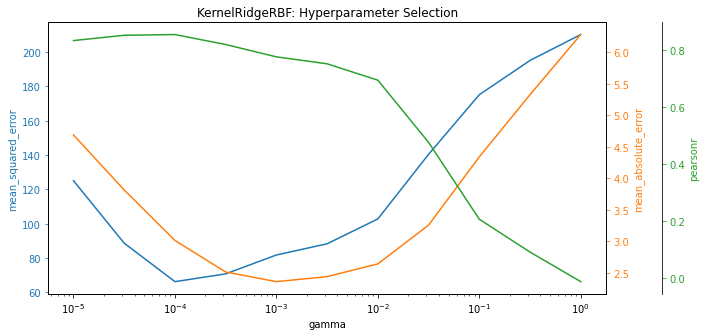

In [35]:
plot_choosing_single_param(krr_rbf_cv, "gamma", "KernelRidgeRBF")

In [36]:
idx = krr_rbf_cv["mean_squared_error"].idxmin(axis=0)
best_gamma = krr_rbf_cv.loc[idx, "gamma"]
best_gamma

0.0001

In [37]:
model_krr_linear = KernelRidge(kernel="linear")
model_krr_rbf = KernelRidge(kernel="rbf", gamma=best_gamma)
model_krr_linear.fit(X_train, y_train)
model_krr_rbf.fit(X_train, y_train)

y_hat_krr_linear = model_krr_linear.predict(X_test)
y_hat_krr_rbf = model_krr_rbf.predict(X_test)

performance["KernelRidgeLinear"] = {
    "model": "KernelRidgeLinear",
    "mean_squared_error": mean_squared_error(y_test, y_hat_krr_linear),
    "mean_absolute_error": mean_absolute_error(y_test, y_hat_krr_linear),
    "pearsonr": pearsonr(y_test, y_hat_krr_linear)[0]
}
performance["KernelRidgeRBF"] = {
    "model": "KernelRidgeRBF",
    "mean_squared_error": mean_squared_error(y_test, y_hat_krr_rbf),
    "mean_absolute_error": mean_absolute_error(y_test, y_hat_krr_rbf),
    "pearsonr": pearsonr(y_test, y_hat_krr_rbf)[0],
    "gamma": best_gamma
}

display(performance["KernelRidgeLinear"])
display(performance["KernelRidgeRBF"])

{'model': 'KernelRidgeLinear',
 'mean_squared_error': 26.178870124719737,
 'mean_absolute_error': 2.3635173421278206,
 'pearsonr': 0.8556386675362446}

{'model': 'KernelRidgeRBF',
 'mean_squared_error': 29.691737050779114,
 'mean_absolute_error': 2.6638504149833335,
 'pearsonr': 0.8449545839459731,
 'gamma': 0.0001}

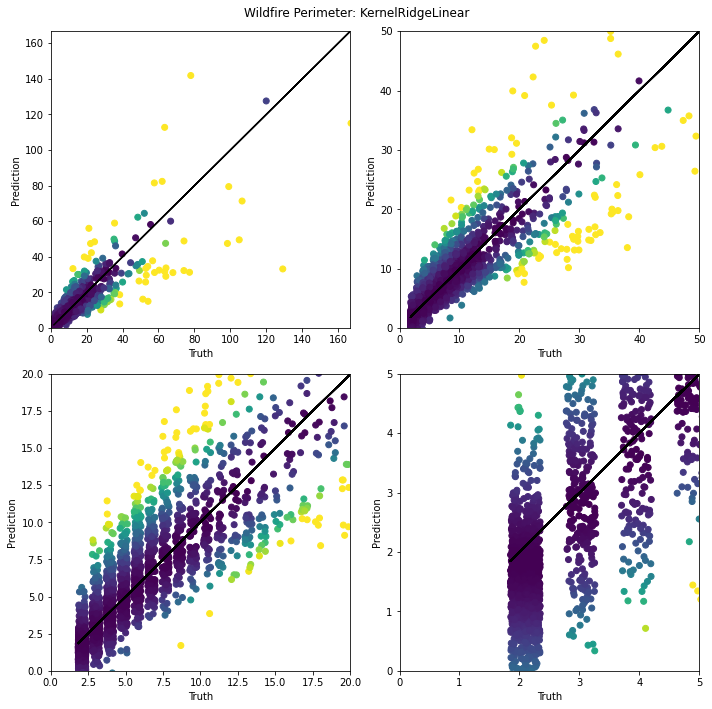

In [38]:
plot_predictions(y_test, y_hat_krr_linear, "KernelRidgeLinear")

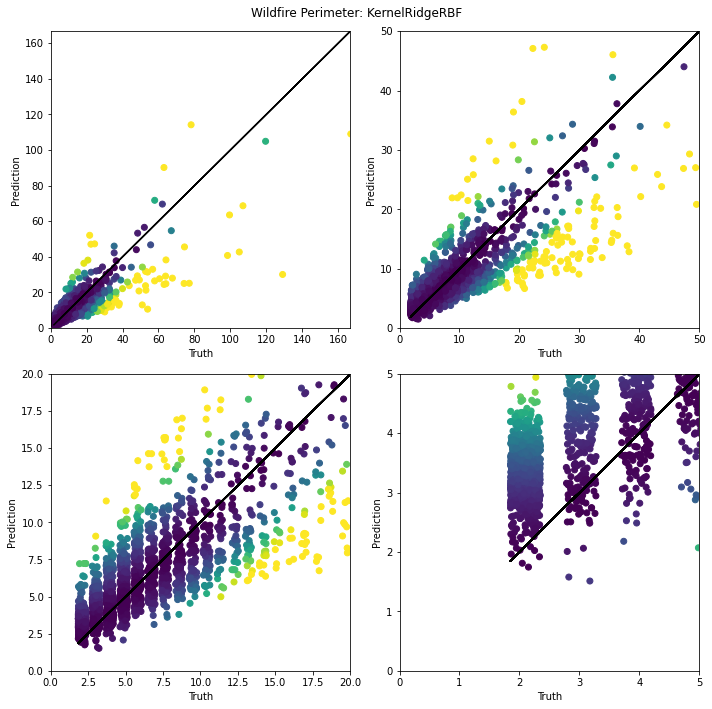

In [39]:
plot_predictions(y_test, y_hat_krr_rbf, "KernelRidgeRBF")

## 6. Random Forest Model
Nonlinear model for greater capacity.

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
kf = KFold(n_splits=3)
max_samples = [0.2, 0.4, 0.6, 0.8, 1]
max_features = [0.2, 0.4, 0.6, 0.8, 1]
params = [(s, f) for s in max_samples for f in max_features]
stats = []

for samples, features in params:
    mse, mae, rho = 0, 0, 0
    for t_idx, v_idx in kf.split(X_train):
        model_forest = RandomForestRegressor(max_samples=samples, max_features=features, random_state=847)
        model_forest.fit(X_train[t_idx], y_train[t_idx])
        y_hat = model_forest.predict(X_train[v_idx])
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
    stats.append({
        "samples": samples,
        "features": features,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })
    print(f"Finished (samples, features) = {samples, features}.")

forest_cv = pd.DataFrame(stats)

Finished (samples, features) = (0.2, 0.2).
Finished (samples, features) = (0.2, 0.4).
Finished (samples, features) = (0.2, 0.6).
Finished (samples, features) = (0.2, 0.8).
Finished (samples, features) = (0.2, 1).
Finished (samples, features) = (0.4, 0.2).
Finished (samples, features) = (0.4, 0.4).
Finished (samples, features) = (0.4, 0.6).
Finished (samples, features) = (0.4, 0.8).
Finished (samples, features) = (0.4, 1).
Finished (samples, features) = (0.6, 0.2).
Finished (samples, features) = (0.6, 0.4).
Finished (samples, features) = (0.6, 0.6).
Finished (samples, features) = (0.6, 0.8).
Finished (samples, features) = (0.6, 1).
Finished (samples, features) = (0.8, 0.2).
Finished (samples, features) = (0.8, 0.4).
Finished (samples, features) = (0.8, 0.6).
Finished (samples, features) = (0.8, 0.8).
Finished (samples, features) = (0.8, 1).
Finished (samples, features) = (1, 0.2).
Finished (samples, features) = (1, 0.4).
Finished (samples, features) = (1, 0.6).
Finished (samples, featur

c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users

In [42]:
forest_cv.describe()

,samples,features,mean_squared_error,mean_absolute_error,pearsonr
count,25.000000,25.000000,25.000000,25.000000,20.000000
mean,0.600000,0.600000,101.419778,2.978865,0.742653
std,0.288675,0.288675,44.946549,1.451961,0.157952
min,0.200000,0.200000,65.129942,1.867607,0.405612
25%,0.400000,0.400000,68.075391,1.907028,0.814070
50%,0.600000,0.600000,69.973831,1.955386,0.816950
75%,0.800000,0.800000,146.227109,4.315293,0.821684
max,1.000000,1.000000,170.124523,5.249606,0.830685


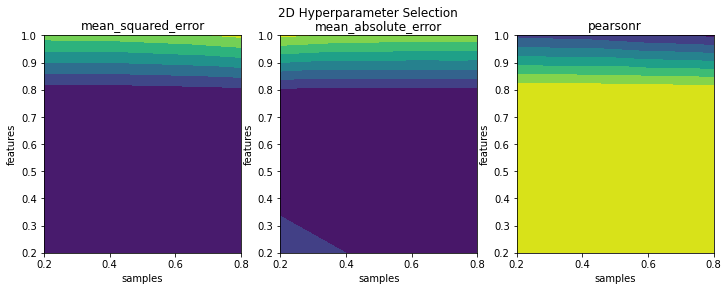

In [43]:
plot_choosing_two_params(forest_cv.dropna(), "samples", "features", "linear", "linear")

In [44]:
idx = forest_cv["mean_squared_error"].idxmin(axis=0)
best_samples, best_features = forest_cv.loc[idx, "samples"], forest_cv.loc[idx, "features"],
best_samples, best_features

(0.6, 0.4)

In [45]:
model_forest = RandomForestRegressor(max_samples=best_samples, max_features=best_features, random_state=847)
model_forest.fit(X_train, y_train)

y_hat_forest = model_forest.predict(X_test)
performance["RandomForestRegressor"] = {
    "model": "RandomForestRegressor",
    "mean_squared_error": mean_squared_error(y_test, y_hat_forest),
    "mean_absolute_error": mean_absolute_error(y_test, y_hat_forest),
    "pearsonr": pearsonr(y_test, y_hat_forest)[0],
    "samples": best_samples,
    "features": best_features
}
performance["RandomForestRegressor"]

{'model': 'RandomForestRegressor',
 'mean_squared_error': 19.20188621485897,
 'mean_absolute_error': 1.6614504701141752,
 'pearsonr': 0.896427412994771,
 'samples': 0.6,
 'features': 0.4}

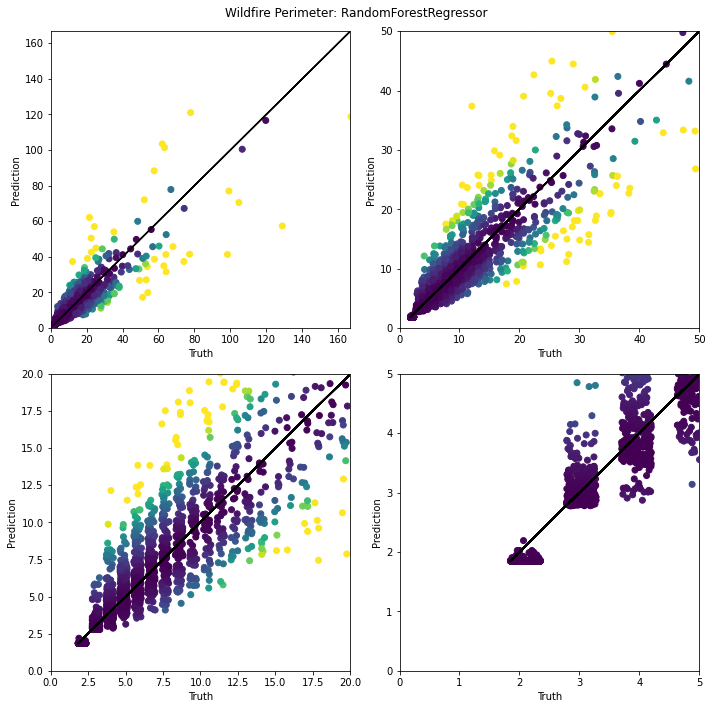

In [46]:
plot_predictions(y_test, y_hat_forest, "RandomForestRegressor")

## 7. Gradient Boosting Tree Model
Nonlinear model for greater capacity. First, determine best loss function.
Then, determine the best subsampling ratio and best feature sampling ratio.
Finally, tune the number of boosting rounds and learning rate.

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
kf = KFold(n_splits=3)
losses = ["ls", "lad", "huber", "quantile"]
stats = []

for loss in losses:
    mse, mae, rho = 0, 0, 0
    for t_idx, v_idx in kf.split(X_train):
        model_gbt = GradientBoostingRegressor(loss=loss, random_state=847)
        model_gbt.fit(X_train[t_idx], y_train[t_idx])
        y_hat = model_gbt.predict(X_train[v_idx])
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
    stats.append({
        "loss": loss,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })
    print(f"Finished loss = {loss}.")

gbt_loss_cv = pd.DataFrame(stats)

Finished loss = ls.
Finished loss = lad.
Finished loss = huber.
Finished loss = quantile.


In [49]:
gbt_loss_cv


,loss,mean_squared_error,mean_absolute_error,pearsonr
0,ls,69.868702,1.985946,0.816213
1,lad,72.219990,1.825374,0.839790
2,huber,71.879237,1.859179,0.808277
3,quantile,78.331133,3.227919,0.824216


It appears that the least squares loss performs best, so we'll proceed with that.
Next, we aim to find the best subsampling ratio and best feature sampling ratio.
Given what we saw when cross-validating the random forest model, we'll narrow
our parameter search space to accelerate computation.

In [50]:
kf = KFold(n_splits=3)
subsamples = [0.6, 0.8, 1.0]
max_features = [0.6, 0.8, 1.0]
params = [(s, f) for s in subsamples for f in max_features]
stats = []

for subsample, features in params:
    mse, mae, rho = 0, 0, 0
    for t_idx, v_idx in kf.split(X_train):
        model_gbt = GradientBoostingRegressor(loss="ls",
            subsample=subsample, max_features=features, random_state=847)
        model_gbt.fit(X_train[t_idx], y_train[t_idx])
        y_hat = model_gbt.predict(X_train[v_idx])
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
    stats.append({
        "subsample": subsample,
        "features": features,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })
    print(f"Finished (samples, features) = {subsample, features}.")

gbt_sampling_cv = pd.DataFrame(stats)

Finished (samples, features) = (0.6, 0.6).
Finished (samples, features) = (0.6, 0.8).
Finished (samples, features) = (0.6, 1.0).
Finished (samples, features) = (0.8, 0.6).
Finished (samples, features) = (0.8, 0.8).
Finished (samples, features) = (0.8, 1.0).
Finished (samples, features) = (1.0, 0.6).
Finished (samples, features) = (1.0, 0.8).
Finished (samples, features) = (1.0, 1.0).


In [51]:
gbt_sampling_cv

,subsample,features,mean_squared_error,mean_absolute_error,pearsonr
0,0.6,0.6,68.574718,2.017842,0.817846
1,0.6,0.8,71.961618,2.079615,0.809707
2,0.6,1.0,69.962280,2.038645,0.811448
3,0.8,0.6,71.853815,2.040927,0.811809
4,0.8,0.8,69.437253,2.012806,0.817724
5,0.8,1.0,74.101675,2.028693,0.804657
6,1.0,0.6,71.146005,2.006480,0.813332
7,1.0,0.8,70.417164,1.982409,0.816636
8,1.0,1.0,69.868702,1.985946,0.816213


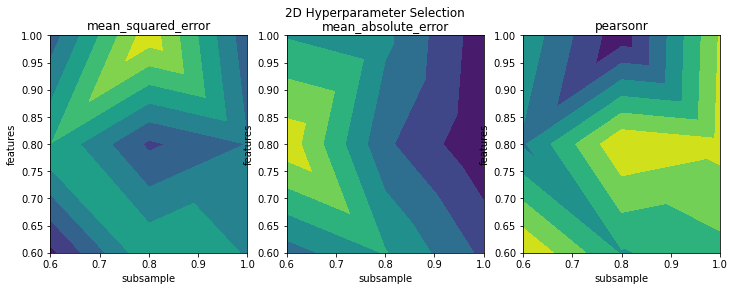

In [52]:
plot_choosing_two_params(gbt_sampling_cv, "subsample", "features", "linear", "linear")

In [53]:
idx = gbt_sampling_cv["mean_squared_error"].idxmin(axis=0)
best_subsample, best_features = gbt_sampling_cv.loc[idx, "subsample"], gbt_sampling_cv.loc[idx, "features"],
best_subsample, best_features

(0.6, 0.6)

Seeing as a subsampling ratio of 0.8 and a feature sampling ratio of 0.8
perform best in cross-validation, we proceed to determine the optimal
learning rate and number of boosting rounds.

In [54]:
kf = KFold(n_splits=3)
learning_rates = [1e-1, 1]
n_estimators = [100, 250]
params = [(lr, n) for lr in learning_rates for n in n_estimators]
stats = []

for lr, n in params:
    mse, mae, rho = 0, 0, 0
    for t_idx, v_idx in kf.split(X_train):
        model_gbt = GradientBoostingRegressor(loss="ls",
            learning_rate=lr, n_estimators=int(n),
            subsample=best_subsample, max_features=best_features, random_state=847)
        model_gbt.fit(X_train[t_idx], y_train[t_idx])
        y_hat = model_gbt.predict(X_train[v_idx])
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
    stats.append({
        "learning_rate": lr,
        "n_estimators": n,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })
    print(f"Finished (learning_rate, n_estimators) = {lr, n}.")

gbt_cv = pd.DataFrame(stats)

Finished (learning_rate, n_estimators) = (0.1, 100).
Finished (learning_rate, n_estimators) = (0.1, 250).
Finished (learning_rate, n_estimators) = (1, 100).
Finished (learning_rate, n_estimators) = (1, 250).


In [55]:
gbt_cv

,learning_rate,n_estimators,mean_squared_error,mean_absolute_error,pearsonr
0,0.1,100,68.574718,2.017842,0.817846
1,0.1,250,67.580024,2.000640,0.821872
2,1.0,100,165.539186,3.450943,0.566813
3,1.0,250,170.763338,3.975715,0.558987


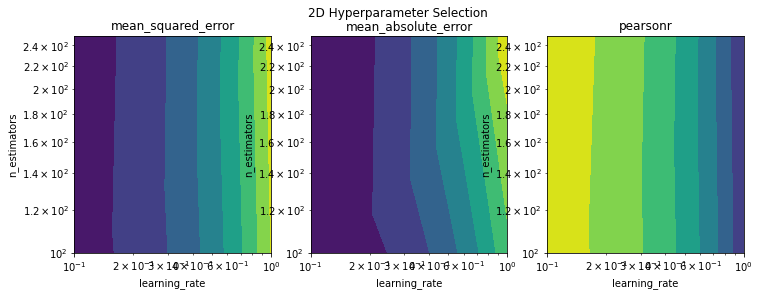

In [56]:
plot_choosing_two_params(gbt_cv, "learning_rate", "n_estimators", "log", "log")


In [57]:
idx = gbt_cv["mean_squared_error"].idxmin(axis=0)
best_lr, best_n = gbt_cv.loc[idx, "learning_rate"], gbt_cv.loc[idx, "n_estimators"],
best_lr, best_n

(0.1, 250)

In [58]:
model_gbt = GradientBoostingRegressor(loss="ls",
      learning_rate=best_lr, n_estimators=best_n,
      subsample=best_subsample, max_features=best_features,
      random_state=847)
model_gbt.fit(X_train, y_train)

y_hat_gbt = model_gbt.predict(X_test)
performance["GradientBoostingRegressor"] = {
    "model": "GradientBoostingRegressor",
    "mean_squared_error": mean_squared_error(y_test, y_hat_gbt),
    "mean_absolute_error": mean_absolute_error(y_test, y_hat_gbt),
    "pearsonr": pearsonr(y_test, y_hat_gbt)[0],
    "learning_rate": best_lr,
    "n_estimators": best_n,
    "subsample": best_subsample,
    "features": best_features
}
performance["GradientBoostingRegressor"]

{'model': 'GradientBoostingRegressor',
 'mean_squared_error': 22.26390462928826,
 'mean_absolute_error': 1.8045179922438122,
 'pearsonr': 0.8827526955129021,
 'learning_rate': 0.1,
 'n_estimators': 250,
 'subsample': 0.6,
 'features': 0.6}

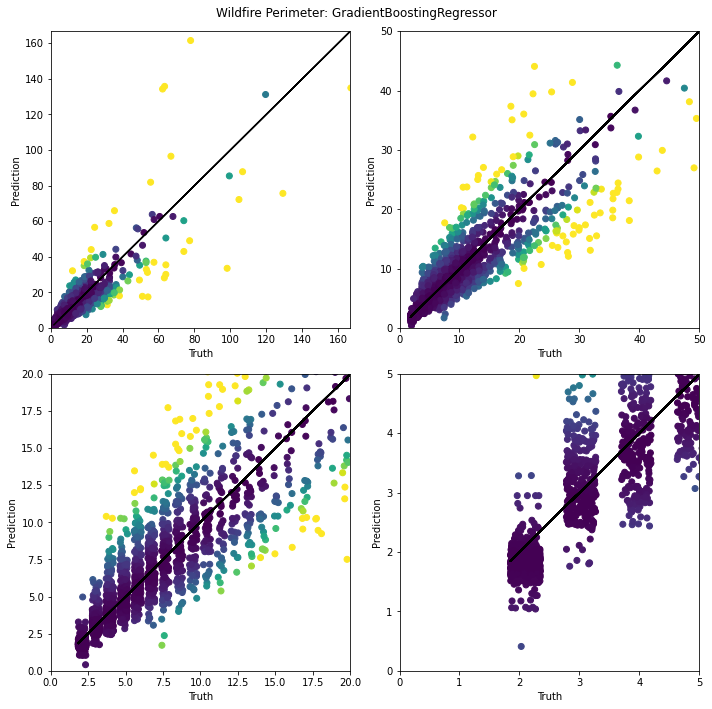

In [59]:
plot_predictions(y_test, y_hat_gbt, "GradientBoostingRegressor")


## 7. Neural Network
Standard MLP ANN model for overparameterized capacity.

In [60]:
from sklearn.neural_network import MLPRegressor

c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Finished (width, depth) = (64, 2).
Finished (width, depth) = (64, 4).
Finished (width, depth) = (64, 8).
Finished (width, depth) = (128, 2).
Finished (width, depth) = (128, 4).
Finished (width, depth) = (128, 8).
Finished (width, depth) = (256, 2).
Finished (width, depth) = (256, 4).
Finished (width, depth) = (256, 8).


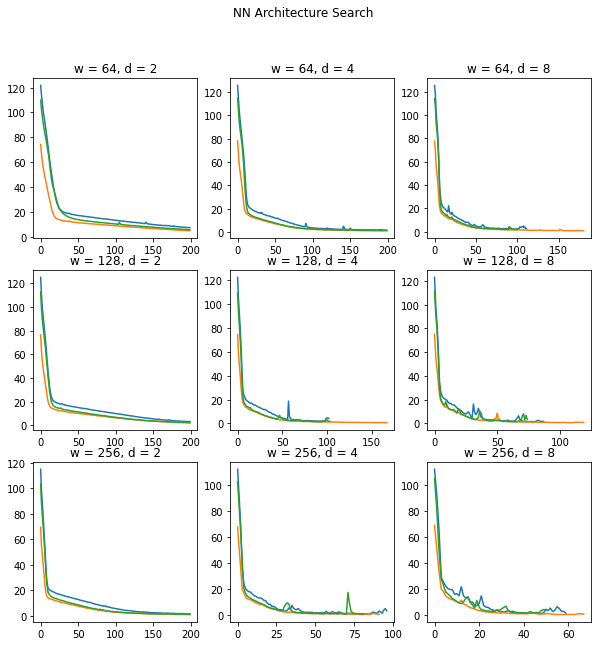

In [61]:
kf = KFold(n_splits=3)
widths = [64, 128, 256]
depths = [2, 4, 8]
params = [(w, d) for w in widths for d in depths]
stats = []
fig, ax = plt.subplots(len(widths), len(depths), figsize=(10, 10))
ax = ax.ravel()

for i, (width, depth) in enumerate(params):
    mse, mae, rho = 0, 0, 0
    curves = []
    for t_idx, v_idx in kf.split(X_train):
        model_nn = MLPRegressor(hidden_layer_sizes=[width]*depth,
            activation="relu", batch_size=256, solver="adam", max_iter=200,
            learning_rate_init=3e-4, verbose=False, random_state=847)
        model_nn.fit(X_train[t_idx], y_train[t_idx])
        y_hat = model_nn.predict(X_train[v_idx])
        mse += mean_squared_error(y_hat, y_train[v_idx]) / kf.n_splits
        mae += mean_absolute_error(y_hat, y_train[v_idx]) / kf.n_splits
        rho += pearsonr(y_hat, y_train[v_idx])[0] / kf.n_splits
        curves.append(model_nn.loss_curve_)
    stats.append({
        "width": width,
        "depth": depth,
        "mean_squared_error": mse,
        "mean_absolute_error": mae,
        "pearsonr": rho
    })
    for j, curve in enumerate(curves):
        ax[i].plot(curve, color=cmap(j))
        ax[i].set_title(f"w = {width}, d = {depth}")
    print(f"Finished (width, depth) = {width, depth}.")

fig.suptitle(f"NN Architecture Search")
plt.show()
nn_cv = pd.DataFrame(stats)

In [62]:
nn_cv

,width,depth,mean_squared_error,mean_absolute_error,pearsonr
0,64,2,48.607024,2.619629,0.857363
1,64,4,55.646449,2.473275,0.837909
2,64,8,49.113216,2.427612,0.848705
3,128,2,52.445549,2.555952,0.852484
4,128,4,58.737195,2.586505,0.852053
5,128,8,61.278195,2.613485,0.860510
6,256,2,52.669198,2.495897,0.853306
7,256,4,44.757901,2.285410,0.866526
8,256,8,42.867396,2.227377,0.869305


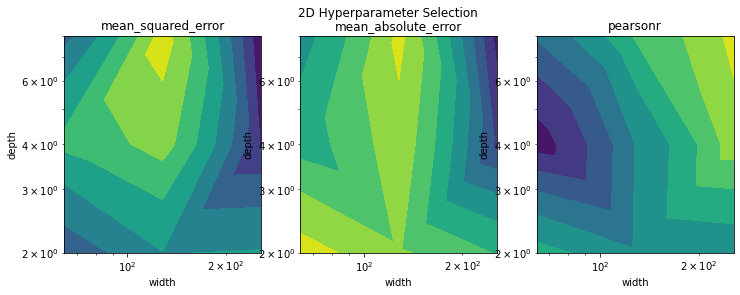

In [63]:
plot_choosing_two_params(nn_cv.dropna(), "width", "depth", "log", "log")

In [64]:
idx = nn_cv["mean_squared_error"].idxmin(axis=0)
best_width, best_depth = nn_cv.loc[idx, "width"], nn_cv.loc[idx, "depth"],
best_width, best_depth

# w=64, d=4, batch=256, lr=3e-4 -- best MSE?
# w=256, d=4, batch=256, lr=1e-4 -- best MAE?
# w=64, d=16, batch=64, lr=1e-4 -- solid overall
# w=64, d=16, batch=2048, lr=1e-4 -- high capacity
# w=64, d=32, batch=4096, lr=3e-4 -- higher capacity -- best so far

(256, 8)

In [72]:
model_nn = MLPRegressor(hidden_layer_sizes=[best_width]*best_depth,
    activation="relu", batch_size=256, solver="adam", max_iter=200,
    learning_rate_init=3e-4, verbose=False, random_state=847)
model_nn.fit(X_train, y_train)

y_hat_nn = model_nn.predict(X_test)
performance["MLPRegressor"] = {
    "model": "MLPRegressor",
    "mean_squared_error": mean_squared_error(y_test, y_hat_nn),
    "mean_absolute_error": mean_absolute_error(y_test, y_hat_nn),
    "pearsonr": pearsonr(y_test, y_hat_nn)[0],
    "width": best_width,
    "depth": best_depth
}
performance["MLPRegressor"]

{'model': 'MLPRegressor',
 'mean_squared_error': 20.838764350040925,
 'mean_absolute_error': 2.048526194596315,
 'pearsonr': 0.8875091877057479,
 'width': 256,
 'depth': 8}

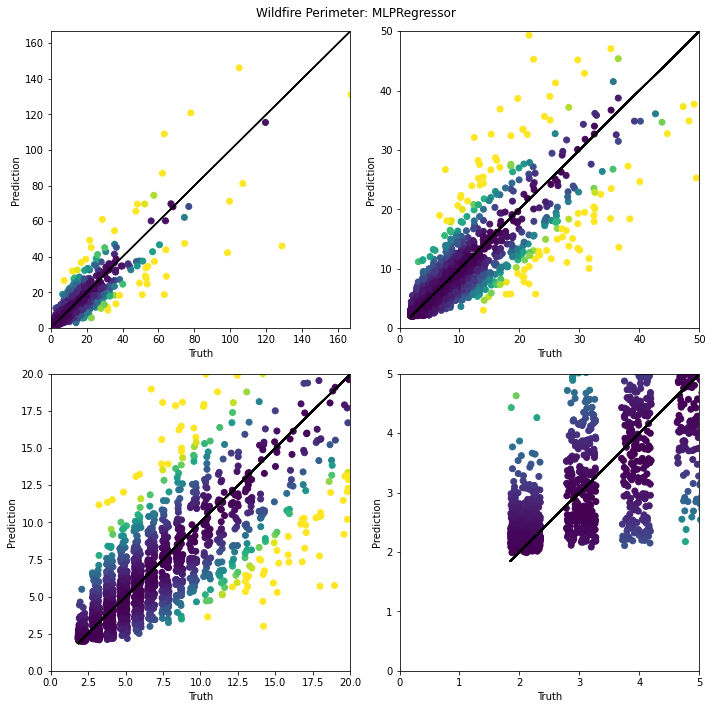

In [73]:
plot_predictions(y_test, y_hat_nn, "MLPRegressor")


In [74]:
performance_df = pd.DataFrame(performance).T
with pd.option_context("display.max_rows", None, "display.max_columns", None, "precision", 4):
    display(performance_df)
    print(" ".join(performance_df.to_latex().split()))



,model,mean_squared_error,mean_absolute_error,pearsonr,alpha,l1_ratio,gamma,samples,features,learning_rate,n_estimators,subsample,width,depth
LinearRegression,LinearRegression,26.2715,2.3908,0.8551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ridge,Ridge,25.7818,2.2213,0.8575,355.648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lasso,Lasso,26.2002,2.0643,0.855,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ElasticNet,ElasticNet,25.8696,2.0798,0.8569,0.1,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KernelRidgeLinear,KernelRidgeLinear,26.1789,2.3635,0.8556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KernelRidgeRBF,KernelRidgeRBF,29.6917,2.6639,0.845,NaN,NaN,0.0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RandomForestRegressor,RandomForestRegressor,19.2019,1.6615,0.8964,NaN,NaN,NaN,0.6,0.4,NaN,NaN,NaN,NaN,NaN
GradientBoostingRegressor,GradientBoostingRegressor,22.2639,1.8045,0.8828,NaN,NaN,NaN,NaN,0.6,0.1,250,0.6,NaN,NaN
MLPRegressor,MLPRegressor,20.8388,2.0485,0.8875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,8


\begin{tabular}{lllllllllllllll} \toprule {} & model & mean\_squared\_error & mean\_absolute\_error & pearsonr & alpha & l1\_ratio & gamma & samples & features & learning\_rate & n\_estimators & subsample & width & depth \\ \midrule LinearRegression & LinearRegression & 26.2715 & 2.3908 & 0.8551 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\ Ridge & Ridge & 25.7818 & 2.2213 & 0.8575 & 355.648 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\ Lasso & Lasso & 26.2002 & 2.0643 & 0.855 & 0.1 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\ ElasticNet & ElasticNet & 25.8696 & 2.0798 & 0.8569 & 0.1 & 0.6 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\ KernelRidgeLinear & KernelRidgeLinear & 26.1789 & 2.3635 & 0.8556 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\ KernelRidgeRBF & KernelRidgeRBF & 29.6917 & 2.6639 & 0.845 & NaN & NaN & 0.0001 & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\ RandomForestRegressor & RandomForestRegressor & 19.2019 & 